In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
# import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pyswarm import pso

In [2]:

# Define file paths for data
data_dir = 'test'

# Get the list of classes dynamically
import os
classes = os.listdir(data_dir)

# Create ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.3)

# Load and split the data into training, validation, and testing sets
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    classes=classes,
    batch_size=32,
    shuffle=True,
    subset='training'
)
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    classes=classes,
    batch_size=32,
    shuffle=False,  # Do not shuffle the validation set
    subset='validation'
)

test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    classes=classes,
    batch_size=32,
    shuffle=False
)


Found 1162 images belonging to 5 classes.
Found 494 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.


In [3]:

# Create InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom head to the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [4]:

# Define objective function for PSO
def objective_function(x):
    # Set the hyperparameters based on the particle values
    learning_rate = x[0]
    num_epochs = math.ceil(x[1])

    # Train the model with the updated hyperparameters
    model.fit(train_generator, validation_data=val_generator, epochs=num_epochs, verbose=0)

    # Obtain the accuracy on the validation set
    _, val_acc = model.evaluate(val_generator)

    # Return the negative accuracy to maximize it in PSO
    return -val_acc


In [5]:

# Define self-adaptive PSO parameters
def self_adaptive_pso(objective_function, lower_bounds, upper_bounds, max_iterations=5, swarm_size=1):
    inertia_weight = 0.5
    c1 = 1.5
    c2 = 1.5
    bounds = list(zip(lower_bounds, upper_bounds))

    # Initialize particles and velocities
    particles = np.random.uniform(lower_bounds, upper_bounds, (swarm_size, len(lower_bounds)))
    velocities = np.random.uniform(-1, 1, (swarm_size, len(lower_bounds)))

    # Initialize personal best positions and fitness values
    personal_best_positions = particles.copy()
    personal_best_fitness = np.array([objective_function(p) for p in particles])

    # Initialize global best position and fitness value
    global_best_index = np.argmin(personal_best_fitness)
    global_best_position = particles[global_best_index]
    global_best_fitness = personal_best_fitness[global_best_index]

    for iteration in range(max_iterations):
        for i in range(swarm_size):
            # Update particle velocity
            velocities[i] = inertia_weight * velocities[i] \
                             + c1 * np.random.rand() * (personal_best_positions[i] - particles[i]) \
                             + c2 * np.random.rand() * (global_best_position - particles[i])

            # Update particle position
            particles[i] += velocities[i]

            # Ensure particle stays within bounds
            particles[i] = np.clip(particles[i], lower_bounds, upper_bounds)

            # Evaluate fitness of the new position
            fitness = objective_function(particles[i])

            # Update personal best if needed
            if fitness < personal_best_fitness[i]:
                personal_best_fitness[i] = fitness
                personal_best_positions[i] = particles[i]

                # Update global best if needed
                if fitness < global_best_fitness:
                    global_best_fitness = fitness
                    global_best_position = particles[i]

        # Update inertia weight (self-adaptation)
        inertia_weight = max(0.4, inertia_weight - 0.002)

    return global_best_position, global_best_fitness


In [6]:

# Set the bounds for the hyperparameters
lower_bounds = [0.1, 1]  # Lower bounds for learning_rate and num_epochs
upper_bounds = [0.2, 2]  # Upper bounds for learning_rate and num_epochs
swarm_size = 2  # Adjust the number of particles



In [7]:

# Perform self-adaptive PSO optimization
best_solution, best_fitness = self_adaptive_pso(objective_function, lower_bounds, upper_bounds, max_iterations=1, swarm_size=1)


16/16 [==============================] - 24s 2s/step - loss: 21449.3555 - accuracy: 0.2713


In [8]:
# Print the best solution and its fitness
print("Best Solution (Learning Rate, Num Epochs):", best_solution)
print("Best Fitness (Validation Accuracy):", -best_fitness)


Best Solution (Learning Rate, Num Epochs): [0.1        1.17032213]
Best Fitness (Validation Accuracy): 0.2712550461292267


In [ ]:
# Train the model with the best hyperparameters
best_num_epochs = 4  # Set the number of epochs to 5
hisory = model.fit(train_generator, validation_data=val_generator, epochs=best_num_epochs)

In [24]:
# Reset the validation generator before evaluation
val_generator.reset()
# Evaluate the model on the validation set
val_pred_labels = np.argmax(model.predict(val_generator), axis=1)
val_true_labels = val_generator.classes

In [27]:
# Calculate classification report and confusion matrix
report = classification_report(val_true_labels, val_pred_labels, target_names=classes, zero_division=1)
confusion_mat = confusion_matrix(val_true_labels, val_pred_labels)

Epoch 1/4
37/37 [==============================] - 279s 8s/step - loss: 1.0227 - accuracy: 0.5757 - val_loss: 19.2652 - val_accuracy: 0.4130
Epoch 2/4
37/37 [==============================] - 275s 7s/step - loss: 0.9033 - accuracy: 0.6188 - val_loss: 6.3224 - val_accuracy: 0.3968
Epoch 3/4
37/37 [==============================] - 287s 8s/step - loss: 0.8017 - accuracy: 0.6738 - val_loss: 6.1083 - val_accuracy: 0.5344
Epoch 4/4
37/37 [==============================] - 286s 8s/step - loss: 0.6926 - accuracy: 0.7057 - val_loss: 4.2733 - val_accuracy: 0.4615


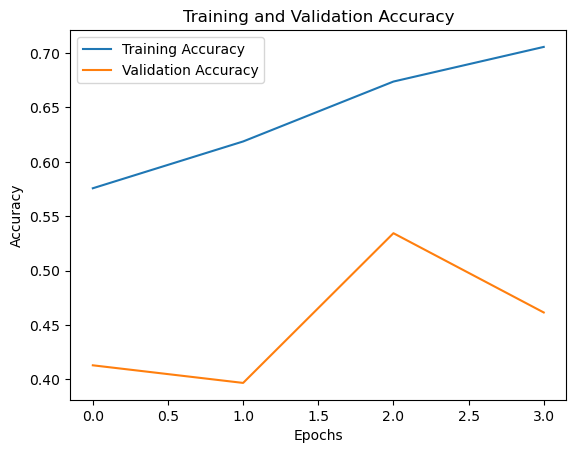

In [10]:
# Train the model with the best hyperparameters
best_num_epochs = 4  # Set the number of epochs to 5
history = model.fit(train_generator, validation_data=val_generator, epochs=best_num_epochs)

# Plot training and validation accuracy
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')

if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Reset the validation generator before evaluation
val_generator.reset()

# Evaluate the model on the validation set
val_pred_labels = np.argmax(model.predict(val_generator), axis=1)
val_true_labels = val_generator.classes


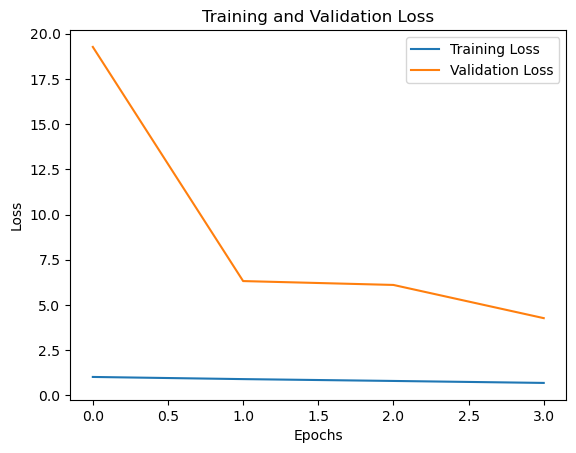

In [11]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

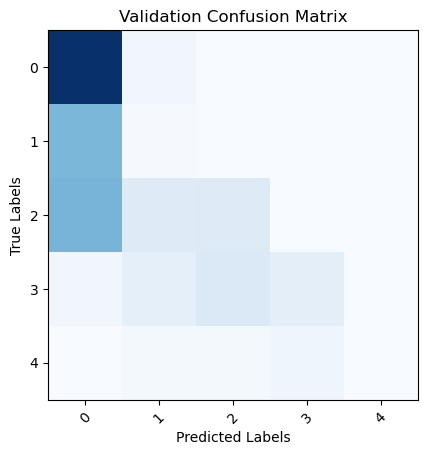

In [34]:

# Plot validation confusion matrix
plt.imshow(confusion_mat, cmap='Blues')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Validation Confusion Matrix')
plt.show()

In [35]:
# Print classification report and confusion matrix
print("Classification Report:")
print(report)
print("\nConfusion Matrix:")
print(confusion_mat)

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.97      0.67       191
           1       0.04      0.02      0.03        88
           2       0.44      0.18      0.25       134
           3       0.69      0.27      0.39        66
           4       1.00      0.00      0.00        15

    accuracy                           0.46       494
   macro avg       0.54      0.29      0.27       494
weighted avg       0.45      0.46      0.38       494


Confusion Matrix:
[[185   6   0   0   0]
 [ 85   2   1   0   0]
 [ 87  23  24   0   0]
 [  6  16  26  18   0]
 [  0   3   4   8   0]]


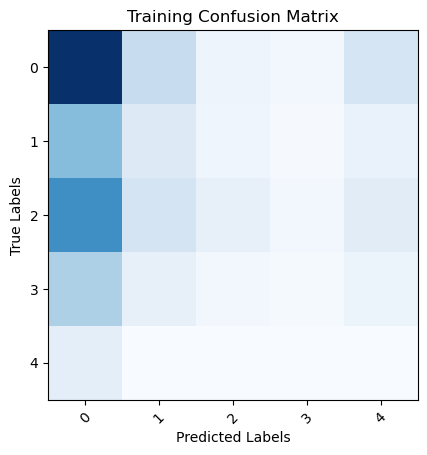

In [13]:
# Reset the training generator before evaluation
train_generator.reset()
# Evaluate the model on the training set
train_pred_labels = np.argmax(model.predict(train_generator), axis=1)
train_true_labels = train_generator.classes

# Calculate confusion matrix for training set
train_confusion_mat = confusion_matrix(train_true_labels, train_pred_labels)

# Plot training confusion matrix
plt.imshow(train_confusion_mat, cmap='Blues')
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Training Confusion Matrix')
plt.show()

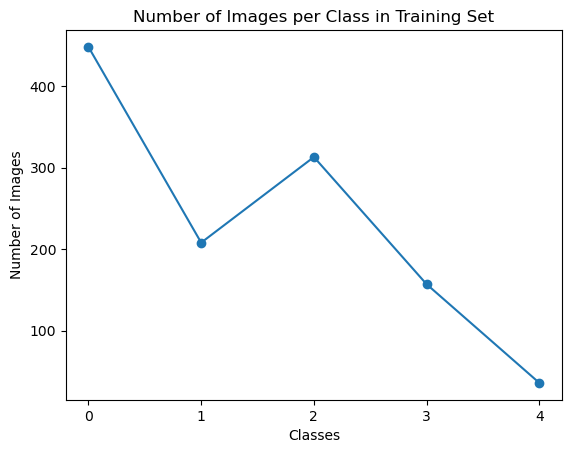

In [19]:

# Count the number of images per class in the training set
num_images_per_class = [sum(train_true_labels == i) for i in range(len(classes))]

# Plot line graph for number of images per class
plt.plot(classes, num_images_per_class, marker='o')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Set')
plt.show()


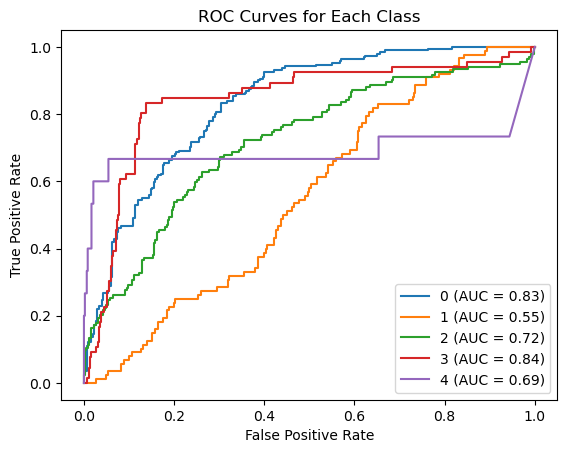

In [20]:
# Calculate ROC curves and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(val_true_labels, model.predict(val_generator)[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend()
plt.show()

Error Rates for Each Class:
0: 100.00%
1: 100.00%
2: 100.00%
3: 100.00%
4: 100.00%


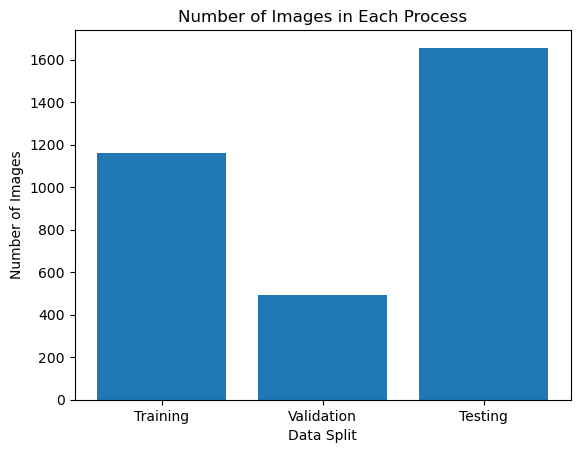

In [22]:
# Calculate error rates for each class
error_rates = [1 - tpr[i] for i in range(len(classes))]
print("Error Rates for Each Class:")
for i, class_name in enumerate(classes):
    print(f"{class_name}: {error_rates[i][0]:.2%}")  # Display the first element as percentage

# Calculate number of images for each process (training, validation, testing)
num_images_per_process = [len(train_generator.classes), len(val_generator.classes), len(test_generator.classes)]

# Plot bar graph
plt.bar(['Training', 'Validation', 'Testing'], num_images_per_process)
plt.xlabel('Data Split')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Process')
plt.show()

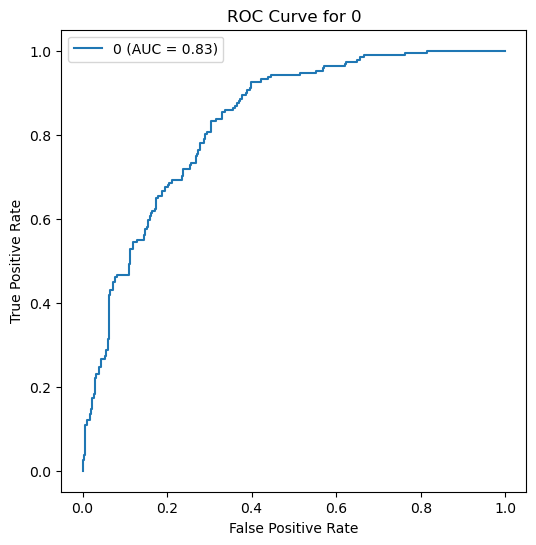

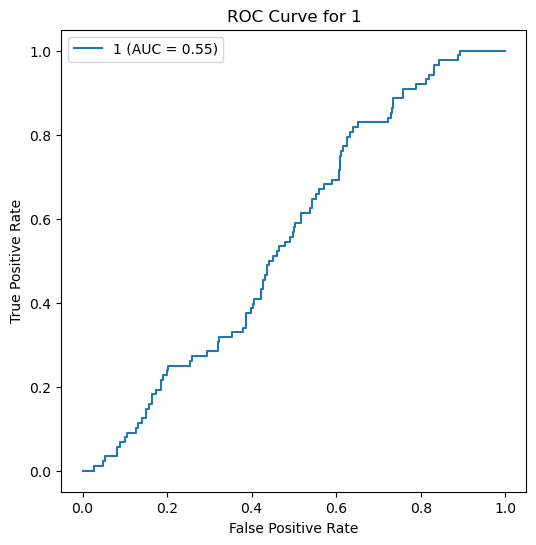

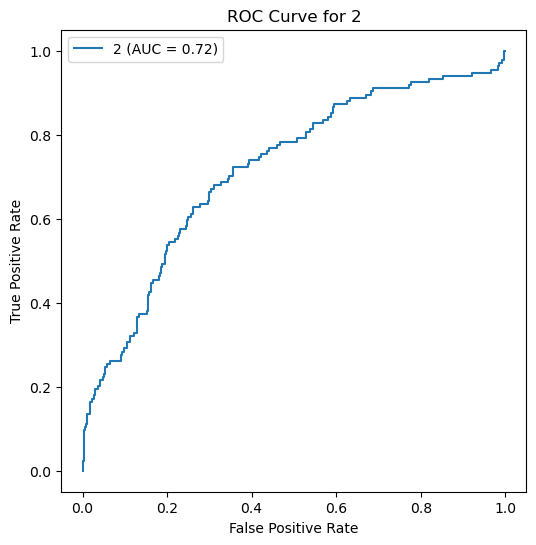

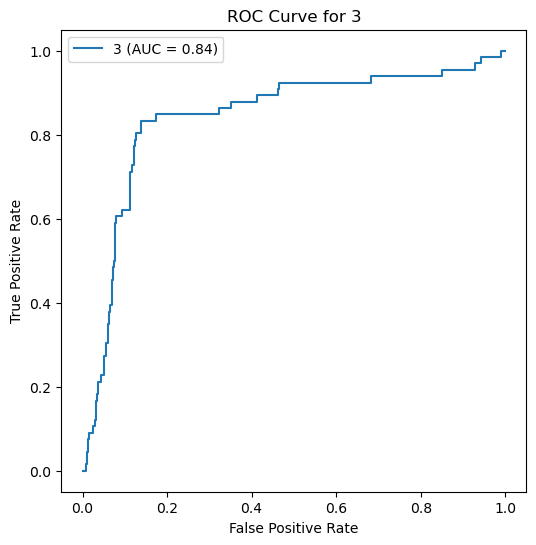

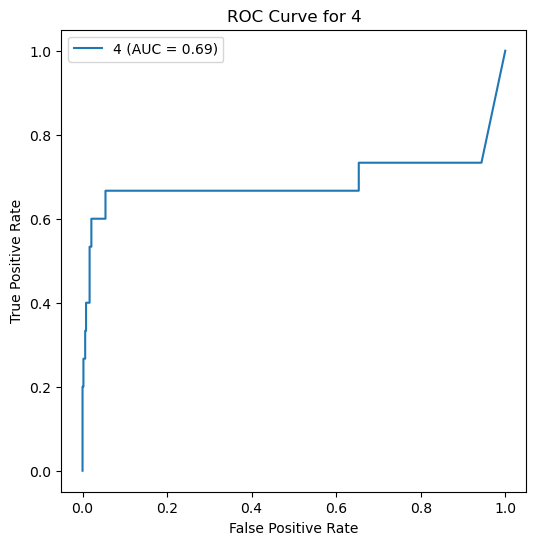

In [23]:
# Plot separate ROC curves and AUC for each class
for i in range(len(classes)):
    plt.figure(figsize=(6, 6))
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {classes[i]}')
    plt.legend()
    plt.show()
